In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [2]:
bjets_DF = pd.read_pickle("./bjetscp.pkl")
#cjets_DF = pd.read_pickle("./cjets.pkl")
#ljets_DF = pd.read_pickle("./ljets.pkl")

Extract the track parameters as our features

In [3]:
%%time
trks=np.zeros((len(bjets_DF), 30, 5))

for i in range(len(bjets_DF)):
    trks[i] = np.array([bjets_DF['tracks'][i]])[:,:,0:5]
    


Wall time: 9.83 s


In [4]:
X = trks # following convention name the features as the vector 'X'

I think we want to ensure all paramters are approx unity in order not to bias the RNN towards a particular feature. phi and theta are already approx unity (order pi), but qOverP is very small order 1e-4 and IP are also small (but scale multiple orders of magnitude) 1e-6 to 1e-2 (unfortunately)

So maybe want to use a min max scaler or some thing.

(array([4.14954e+05, 3.90070e+04, 2.75800e+04, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]),
 array([2.84850237e-10, 2.49984511e-05, 4.99966173e-05, ...,
        2.49731683e-02, 2.49981665e-02, 2.50231647e-02]),
 <a list of 1001 Patch objects>)

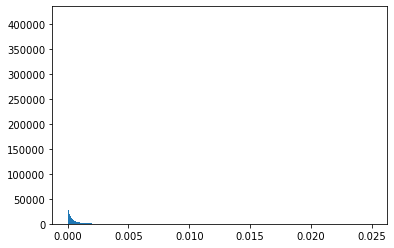

In [77]:
d0s = np.reshape(X[:,:,0],(3000000))
d0s = d0s[~(d0s == 0)]
d0s
plt.hist(d0s,bins='scott') # I believe this is the array containing all the d0s

In [102]:
print(np.mean(X[:,:,0]*1e4))
print(np.mean(X[:,:,1]*1e6))
print(np.mean(X[:,:,4]*1e4))
# so we will apply the above multiples, this will bring the averages to about unity (unfortunately some outliers will
# be very large, so probs better to use a min max scaler or something but then exclude 0?)

0.9593741068094633
-0.15895918021723643
2.029405298393992


Here we scale all the features to bring them to average unity, this is very simplistic so we need a better way in future

It means it works faster.

In [103]:
#firsttime=True

In [104]:
#if firsttime==True:
#    X[:,:,0]=X[:,:,0]*1e4
#    X[:,:,1]=X[:,:,1]*1e6
#    X[:,:,4]=X[:,:,4]*1e4
#    firsttime = False

Here we instead use a min-max scaler to try and solve the problem of scale i.e. certain IPs are 10^4 times larger than others. The min-max scaler means all features will be scaled equivalently.

In [121]:
# minmax scaling

In [142]:
ting=np.array([[12,32,121,32,21],[222222,321323,121231231,123123123,1312311]])
ting=ting.T

In [143]:
scaler=MinMaxScaler()
scaler.fit(ting)
scaler.transform(ting)

array([[0.00000000e+00, 0.00000000e+00],
       [1.83486239e-01, 8.06348848e-04],
       [1.00000000e+00, 9.84606362e-01],
       [1.83486239e-01, 1.00000000e+00],
       [8.25688073e-02, 8.86965833e-03]])

In [144]:
ting

array([[       12,    222222],
       [       32,    321323],
       [      121, 121231231],
       [       32, 123123123],
       [       21,   1312311]])

And the secondary and tertiary vertices as our labels

In [106]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [107]:
X_train=X[:80000]
X_test=X[80000:]
y_train=y[:80000]
y_test=y[80000:]

In [108]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:80000]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[80000:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:80000]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[80000:]
plt.show()

0.0036985106615352826
0.007068593500451309


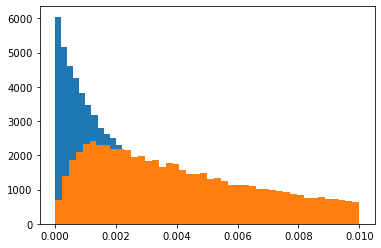

In [109]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


0.0036550417303922366
0.006973962985526242


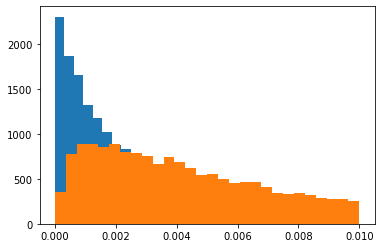

In [110]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [111]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 100
nDense = 20

In [112]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [113]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.8)(lstm)

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt)

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [114]:
myRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 30, 5)             0         
_________________________________________________________________
masking_2 (Masking)          (None, 30, 5)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 20)                2020      
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 126       
Total params: 44,546
Trainable params: 44,546
Non-trainable params: 0
_________________________________________________________________


In [115]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [116]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [117]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [118]:
nEpochs = 50

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.25,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

Train on 60000 samples, validate on 20000 samples
Epoch 1/50
60000/60000 [==============================] - 18s 308us/step - loss: 2.5286 - mean_absolute_error: 2.5286 - val_loss: 2.1244 - val_mean_absolute_error: 2.1244
Epoch 2/50
60000/60000 [==============================] - 20s 340us/step - loss: 2.0533 - mean_absolute_error: 2.0533 - val_loss: 1.8105 - val_mean_absolute_error: 1.8105
Epoch 3/50
60000/60000 [==============================] - 19s 322us/step - loss: 1.9038 - mean_absolute_error: 1.9038 - val_loss: 1.7100 - val_mean_absolute_error: 1.7100
Epoch 4/50
60000/60000 [==============================] - 19s 325us/step - loss: 1.8188 - mean_absolute_error: 1.8188 - val_loss: 1.6108 - val_mean_absolute_error: 1.6108
Epoch 5/50
60000/60000 [==============================] - 20s 341us/step - loss: 1.7678 - mean_absolute_error: 1.7678 - val_loss: 1.5073 - val_mean_absolute_error: 1.5073
Epoch 6/50
60000/60000 [==============================] - 21s 342us/step - loss: 1.6908 - mean_

Epoch 25/50
60000/60000 [==============================] - 20s 328us/step - loss: 1.3321 - mean_absolute_error: 1.3321 - val_loss: 1.0547 - val_mean_absolute_error: 1.0547
Epoch 26/50
60000/60000 [==============================] - 20s 338us/step - loss: 1.3348 - mean_absolute_error: 1.3348 - val_loss: 1.0924 - val_mean_absolute_error: 1.0924
Epoch 27/50
60000/60000 [==============================] - 20s 328us/step - loss: 1.3316 - mean_absolute_error: 1.3316 - val_loss: 1.0782 - val_mean_absolute_error: 1.0782
Epoch 28/50
60000/60000 [==============================] - 20s 330us/step - loss: 1.3197 - mean_absolute_error: 1.3197 - val_loss: 1.0396 - val_mean_absolute_error: 1.0396
Epoch 29/50
60000/60000 [==============================] - 20s 336us/step - loss: 1.3200 - mean_absolute_error: 1.3200 - val_loss: 1.0391 - val_mean_absolute_error: 1.0391
Epoch 30/50
60000/60000 [==============================] - 20s 337us/step - loss: 1.3075 - mean_absolute_error: 1.3075 - val_loss: 1.0143 - 

60000/60000 [==============================] - 20s 330us/step - loss: 1.2376 - mean_absolute_error: 1.2376 - val_loss: 0.9524 - val_mean_absolute_error: 0.9524


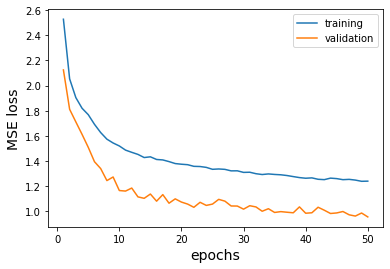

In [119]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

In [19]:
results=myRNN.predict(X_test)

In [20]:
y_test

array([[-1.24140129e+00, -8.88192000e-01,  9.94241735e-01,
        -3.48758960e+00, -2.26321569e+00,  2.46167972e+00],
       [-8.51117036e+00, -1.26717577e+00, -6.36053884e+00,
        -1.91485971e+01, -2.83072612e+00, -1.51046790e+01],
       [-1.36862621e-02, -4.78984242e-02, -2.67514389e-01,
        -4.80987654e-02, -1.49361153e-01, -6.03017945e-01],
       ...,
       [-1.60835268e-01, -1.19740543e-02, -1.07830609e-01,
        -1.10618069e+00, -1.17571043e-01, -7.76054401e-01],
       [-7.25770497e-02, -3.50309500e-02, -2.60381413e-01,
        -3.58773002e+00, -1.45284391e+00, -1.34700448e+01],
       [ 4.17528040e+00, -1.00886561e+00,  2.89703501e+00,
         5.59305105e+00, -1.35187053e+00,  4.07725993e+00]])

In [23]:
(results-y_test)/y_test

array([[ 0.41204707,  0.58094349,  0.37507779, -0.02337146,  0.21841183,
         0.05194956],
       [-0.56747293, -0.43625976, -0.47986848, -0.66950336, -0.54154851,
        -0.6110813 ],
       [ 1.09298498,  0.11684774,  0.93079942,  0.84642937, -0.06236174,
         1.25966563],
       ...,
       [ 3.53251925,  4.77539957,  3.57591692,  0.6798615 ,  0.63707265,
         0.71351295],
       [14.09553344, 11.46632475, 10.55105835, -0.43284465, -0.4594923 ,
        -0.57675777],
       [-0.398921  , -0.41353872, -0.44652154, -0.15028829, -0.1378671 ,
        -0.20613938]])

In [27]:
bjets_DF.iloc[-1]

jet_energy                                               43075.4
jet_flavour                                                    5
secVtx_x                                              0.00417528
secVtx_y                                             -0.00100887
secVtx_z                                              0.00289704
terVtx_x                                              0.00559305
terVtx_y                                             -0.00135187
terVtx_z                                              0.00407726
tracks         [[2.010621651929816e-06, -4.989406079403125e-0...
Name: 99999, dtype: object

In [ ]:
# look at worst perfoming cases and examine the tracks
# look at actual uncertainty on overlap for the vertex
# re-run with minimised errors on tracks see if performance is better

In [152]:
myRNN.predict(np.array([X_test[2]]))

array([[-0.05486715, -0.45196092, -2.455217  , -0.1861686 , -0.99255735,
        -5.3714914 ]], dtype=float32)

couple of things, first the RNN looks like it predicts the same value for all cases. This might be because it uses the null tracks at the end of every single jet and just predicts off of those.
Maybe should consider predicting values that are at least order unity, because mse is gonna be very small otherwise, so convert the vertices into different units (I dunno maybe millimeters or microns)